In [1]:
import numpy as np
#import matplotlib.pyplot as plt
#import music21 as m21
import datetime
import csv
import ast
#from matplotlib import pyplot
import pandas as pd
import os
import sys
from itertools import groupby
import random

from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Masking
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model


In [2]:
#IMPORT EXERCISE CSVs
loadexercises = open('exercise_dictionary_001-589_revised200428.csv', mode='r', newline = '')
reader = csv.reader(loadexercises)
e = {}
for row in reader:
    key, value = row
    e[key] = ast.literal_eval(value)
loadexercises.close()

monoexercises = open('exercise_dictionary_001-589-MONOPHONIC_revised200428.csv', mode='r', newline = '')
reader = csv.reader(monoexercises)
m = {}
for row in reader:
    key, value = row
    m[key] = ast.literal_eval(value)
monoexercises.close()

uniqueex = open('exercise_dictionary_431and590.csv', mode='r', newline = '')
reader = csv.reader(uniqueex)
u = {}
for row in reader:
    key, value = row
    u[key] = ast.literal_eval(value)
uniqueex.close()



#ITERATION UTILITIES
def iterate(ex_key, exercise):
    
    #pre-transpose
    note, stick, duration = zip(*exercise)
    maxpitch = np.amax([y for x in note for y in (x if isinstance(x, list) else (x,))]) #inline nested for loop to flatten the list of ints or lists
    minpitch = np.amin([y for x in note for y in (x if isinstance(x, list) else (x,))]) #inline nested for loop to flatten the list of ints or lists
    transpose_interval = 36 - minpitch
    if maxpitch - minpitch > 61:
        print("Range greater than 5 octaves, cannot be played")
        #return 0
    #note = note + transpose_interval #set the lowest of the exercise to be low C
    note = tuple([i + transpose_interval for i in note])
    
    #iterate through keys
    #newmaxpitch = np.amax([y for x in note for y in (x if isinstance(x, list) else (x,))]) #inline nested for loop to flatten the list of ints or lists
    newmaxpitch = maxpitch + transpose_interval
    n_iterations = 97 - newmaxpitch
    d = {}   
    for i in range(0, n_iterations):
        d["{0}_it{1}".format(ex_key, i)] = list(zip((x+i if isinstance(x, int) | isinstance(x, np.int32) else [y+i for y in x] for x in note), stick, duration)) #inline nested if/else/for to account for ints or lists (or int32s, which occur when there are no doublestops)
    
    return d


def iterate_dictionary(exercise_dictionary):
    it_e = {}
    for ex in exercise_dictionary:
        it_e.update(iterate(ex, exercise_dictionary[ex]))

    count = 0
    for ex_it in it_e:
        count = count + 1
    print("Iterated exercise dictionary contains {0} exercises.".format(count))
    
    return it_e, count   

def mono_iterate(ex_key, exercise):
    
    #pre-transpose
    note, stick, duration = zip(*exercise)
    maxpitch = np.amax(note)
    minpitch = np.amin(note)
    transpose_interval = 36 - minpitch
    if maxpitch - minpitch > 61:
        print("Range greater than 5 octaves, cannot be played")
        return 0
    note = note + transpose_interval #set the lowest of the exercise to be low C
    
    #iterate through keys
    newmaxpitch = np.amax(note)
    n_iterations = 97 - newmaxpitch
    d = {}   
    for i in range(0, n_iterations):
        d["{0}_it{1}".format(ex_key, i)] = list(zip(np.array(note) + i, stick, duration))
    
    return d


def mono_iterate_dictionary(exercise_dictionary):
    it_e = {}
    for ex in exercise_dictionary:
        it_e.update(mono_iterate(ex, exercise_dictionary[ex]))

    count = 0
    for ex_it in it_e:
            count = count + 1
    print("Iterated exercise dictionary contains {0} exercises.".format(count))
    
    return it_e, count   

def u_iterate(ex_key, u_exercise):
    
    #pre-transpose, only by octave
    note, stick, duration = zip(*u_exercise)
    maxpitch = np.amax(note)
    minpitch = np.amin(note)
    transpose_interval = -12*np.floor((minpitch-36)/12)
    if maxpitch - minpitch > 61:
        print("Range greater than 5 octaves, cannot be played")
        return 0
    note = np.ndarray.astype(note + transpose_interval, dtype='int32') #set the lowest of the exercise to be in lowest octave
    
    #iterate through keys, only by octave
    newmaxpitch = np.amax(note)
    n_iterations = np.floor((97-newmaxpitch)/12)
    d = {}   
    for i in range(0, int(n_iterations)):
        d["{0}_it{1}".format(ex_key, i)] = list(zip(np.array(note) + 12*i, stick, duration))
    
    return d


def u_iterate_dictionary(u_exercise_dictionary):
    it_e = {}
    for ex in u_exercise_dictionary:
        it_e.update(u_iterate(ex, u_exercise_dictionary[ex]))

    count = 0
    for ex_it in it_e:
            count = count + 1
    print("Iterated exercise dictionary contains {0} exercises.".format(count))
    
    return it_e, count  

#VECTORIZE DATA
def vectorize_x(exercise):
    x_vec = []
    length = 0
    for note in exercise:
        length = length + 1
        x = np.zeros(62).tolist()
        if isinstance(note[0], int) | isinstance(note[0], np.int32): #some conditions to account for ints and lists
            x[note[0]-36] = 1
        elif isinstance(note[0], list):
            for ds in note[0]:
                x[ds-36] = 1
        x[61] = note[2]
        x_vec.append(x)
    return x_vec
    #return np.array(x_vec).reshape(1, length, 62)

def vectorize_y(exercise):
    y_vec = []
    length = 0
    for note in exercise:
        length = length + 1
        y = np.zeros(4).tolist()
        if isinstance(note[1], int) | isinstance(note[1], np.int32): #some conditions to account for ints and lists
            y[note[1]-1] = 1
        elif isinstance(note[1], list):
            for ds in note[1]:
                y[ds-1] = 1
        y_vec.append(y)
    return y_vec
    #return np.array(y_vec).reshape(1, length, 4)
    
def vectorize_dataset(ex_dict):  
    it_list_x = []
    it_list_y = []
    for ex_it in ex_dict:
            it_list_x.append(vectorize_x(ex_dict[ex_it]))
            it_list_y.append(vectorize_y(ex_dict[ex_it]))
    return it_list_x, it_list_y
    
def mono_vectorize_x(exercise):
    x_vec = []
    length = 0
    for note in exercise:
        length = length + 1
        x = np.zeros(62).tolist()
        x[note[0]-36] = 1
        x[61] = note[2]
        x_vec.append(x)
    return x_vec
    #return np.array(x_vec).reshape(1, length, 62) #(samples, timesteps, features)

def mono_vectorize_y(exercise):
    y_vec = []
    length = 0
    for note in exercise:
        length = length + 1
        y = np.zeros(4).tolist()
        y[note[1]-1] = 1
        y_vec.append(y)
    return y_vec
    #return np.array(y_vec).reshape(1, length, 4)   
    
def mono_vectorize_dataset(ex_dict):  
    it_list_x = []
    it_list_y = []
    for ex_it in ex_dict:
            it_list_x.append(mono_vectorize_x(ex_dict[ex_it]))
            it_list_y.append(mono_vectorize_y(ex_dict[ex_it]))
    return it_list_x, it_list_y


#SPLIT TEST SET NOVEMBER EDIT - RANDOM SAMPLE RATHER THAN SYSTEMATIC
def split_data(ex_dict, ex_dict_length, ratio = 0.1):
    train_ex = {}
    test_ex = {}
    sample = random.sample(range(0, ex_dict_length-1), round(ratio*ex_dict_length))
    for enum, key in enumerate(ex_dict):
        if enum in sample:
            test_ex[key] = ex_dict[key]
        else:
            train_ex[key] = ex_dict[key]
    return train_ex, test_ex

#NOVEMBER 11 EDIT: SPLIT SET FOR SUBJECTIVE EVALUATION
def split_data_subjective(ex_dict, samples_size = 30):
    n_exercises = len(ex_dict)
    quant_ex = {}
    subj_ex = {}
    sample = random.sample(range(0,n_exercises-1),samples_size)
    for enum, key in enumerate(ex_dict):
        if enum in sample:
            subj_ex[key] = ex_dict[key]
        else:
            quant_ex[key] = ex_dict[key]
    return quant_ex, subj_ex
        
    


In [3]:
#Partitioning exercises for subjective evaluation. The 'u' exercises are excluded due to their uniqueness importance in training and less importance in subjective evaluation

random.seed(42)

quant_e, subj_e = split_data_subjective(e)
# with open('subj_e.csv', 'w') as csv_file:
#     writer = csv.writer(csv_file)
#     for key, value in subj_e.items():
#         writer.writerow([key, value])
        
subj_m = {key:value for key, value in subj_e.items() if key in m}
# with open('subj_m.csv', 'w') as csv_file:
#     writer = csv.writer(csv_file)
#     for key, value in subj_m.items():
#         writer.writerow([key, value])

quant_m = {key:value for key, value in m.items() if key not in subj_m}
        

In [5]:
#FORMAT EXERCISES

iterate_quant_e, iterate_quant_e_length = iterate_dictionary(quant_e)
train_it, test_it = split_data(iterate_quant_e, iterate_quant_e_length)

iterate_quant_m, iterate_quant_m_length = mono_iterate_dictionary(quant_m)
train_m_it, test_m_it = split_data(iterate_quant_m, iterate_quant_m_length)

iterate_u, iterate_u_length = u_iterate_dictionary(u)
train_u_it, test_u_it = split_data(iterate_u, iterate_u_length)

train_it.update(train_u_it)
test_it.update(test_u_it)

train_m_it.update(train_u_it)
test_m_it.update(test_m_it)

X, Y = vectorize_dataset(train_it)
X_test, Y_test = vectorize_dataset(test_it)

X_m, Y_m = mono_vectorize_dataset(train_m_it)
X_m_test, Y_m_test = mono_vectorize_dataset(test_m_it)

X_pad = pad_sequences(X, dtype='float32')
Y_pad = pad_sequences(Y, dtype='float32')

X_m_pad = pad_sequences(X_m, dtype='float32')
Y_m_pad = pad_sequences(Y_m, dtype='float32')

X_test_pad = pad_sequences(X_test, dtype='float32')
Y_test_pad = pad_sequences(Y_test, dtype='float32')

X_m_test_pad = pad_sequences(X_m_test, dtype='float32')
Y_m_test_pad = pad_sequences(Y_m_test, dtype='float32')

input_timesteps = max(len(X_pad[0]), len(X_test_pad[0]))

Iterated exercise dictionary contains 31272 exercises.
Iterated exercise dictionary contains 17643 exercises.
Iterated exercise dictionary contains 173 exercises.


In [9]:
del e, m, u, subj_e, subj_m, iterate_quant_e, iterate_quant_m, train_it, test_it, train_m_it, test_m_it, iterate_u, train_u_it, test_u_it, X, Y, X_test, Y_test, X_m, Y_m, X_m_test, Y_m_test

In [12]:
# DEFINE GRID SEARCH

def grid_search_network_size(modeltype, size=[2, 10, 50], depth=[1, 2]):
    for network_size in size:
        for layer_depth in depth:
            start = datetime.datetime.now()

            date = str(datetime.date.today())

            if modeltype == 'LSTM_Bi_Poly':
                activationfunction = 'sigmoid'
                lossfunction = 'binary_crossentropy'
                bidirectional = True
                dataset = 'poly'
            elif modeltype == 'LSTM_Bi_Mono':
                activationfunction = 'softmax'
                lossfunction = 'categorical_crossentropy'
                bidirectional = True
                dataset = 'mono'
            elif modeltype == 'LSTM_Uni_Poly':
                activationfunction = 'sigmoid'
                lossfunction = 'binary_crossentropy'
                bidirectional = False
                dataset = 'poly'
            elif modeltype == 'LSTM_Uni_Mono':
                activationfunction = 'softmax'
                lossfunction = 'categorical_crossentropy'
                bidirectional = False
                dataset = 'mono'
            else:
                print("Invalid model type.")
                break

            optimizertype = 'adam'
            opt = optimizers.Adam(lr=0.01)
            metric = 'accuracy'
            kfoldsplits = 5
            numepochs = 100 ##||--SPEED TEST CHANGE--||##

            print('Model: {0}\nSize: {1}\nDepth: {2}'.format(modeltype, network_size, layer_depth))

            path = "./{0}_{1}_{2}_NS-{3}_LD-{4}".format(str(datetime.date.today()),modeltype,dataset, network_size, layer_depth)
            if not os.path.exists(path):
                os.mkdir(path)

            #K-Fold Cross Validation
            kfold = KFold(n_splits = kfoldsplits, shuffle = True, random_state = 1)
            cvscores = []
            fold = 0

            #Dataset selection (MONO/POLY)
            if dataset == 'poly':
                X_cv, Y_cv = X_pad, Y_pad
                X_test_cv, Y_test_cv = X_test_pad, Y_test_pad
            elif dataset == 'mono':
                X_cv, Y_cv = X_m_pad, Y_m_pad
                X_test_cv, Y_test_cv = X_m_test_pad, Y_m_test_pad
            else:
                print("Invalid dataset.")
                break

            #Training        
            for train, test in kfold.split(X_cv, Y_cv):  
                fold +=1

                K.clear_session()

                #Callbacks ##||--SPEED TEST VARIABLE--||##
                es = EarlyStopping(monitor='val_loss', patience = 5, verbose=0)
                #mc = ModelCheckpoint('{0}_{1}_{2}_NS-{3}/{1}_{2}_NS-{3}_Fold{4}_best_model.h5'.format(date,modeltype,dataset, network_size,fold), monitor='val_loss', save_best_only=True, verbose=0)

                #Model
                model = Sequential()
                model.add(Masking(mask_value = 0, input_shape = (input_timesteps, 62)))
                if bidirectional == True:
                    model.add(Bidirectional(LSTM(network_size, input_shape=(None,62), return_sequences = True)))
                    for i in range(layer_depth-1):The 
                        model.add(Bidirectional(LSTM(network_size, return_sequences = True)))
                else:
                    model.add(LSTM(network_size, input_shape=(None,62), return_sequences = True))
                    for i in range(layer_depth-1):
                        model.add(LSTM(network_size, return_sequences = True))
                model.add(TimeDistributed(Dense(4, activation=activationfunction)))
                model.compile(loss=lossfunction, optimizer=opt, metrics=[metric])

                history = model.fit(X_cv[train], Y_cv[train], validation_data=(X_cv[test], Y_cv[test]), epochs = numepochs, callbacks = [es], verbose = 0) #Need [mc,es] for checkpoint callback

                model.save_weights('{0}_{1}_{2}_NS-{3}_LD-{4}/{1}_{2}_NS-{3}_LD-{4}_Fold{5}_best_model'.format(date,modeltype,dataset, network_size,layer_depth,fold))

                pd.DataFrame.from_dict(history.history).to_csv('{0}_{1}_{2}_NS-{3}_LD-{4}/{1}_{2}_NS-{3}_LD-{4}_History_Fold{5}.csv'.format(date,modeltype,dataset, network_size,layer_depth,fold), index=False)


                #separate model evaluation
                ##saved_model = load_model('{0}_{1}_{2}_NS-{3}_LD-{4}/{1}_{2}_NS-{3}_LD-{4}_Fold{5}_best_model.h5'.format(date,modeltype,dataset, network_size,layer_depth,fold))

                scores = model.evaluate(X_test_cv, Y_test_cv, verbose = 0)
                print("Fold %d %s: %.2f%%" % (fold, model.metrics_names[1], scores[1]*100))
                cvscores.append(scores[1] * 100)
                del model


            finalresults = "CV mean: %.2f%%\nCV std: %.2f%%\n" % (np.mean(cvscores), np.std(cvscores))
            print(finalresults)

            bestfoldscore = max(cvscores)
            bestfold = cvscores.index(bestfoldscore)+1

            end = datetime.datetime.now()

            #Save log file
            f = open("{0}_{1}_{2}_NS-{3}_LD-{4}/{1}_{2}_NS-{3}_LD-{4}_KFold_Log.txt".format(date,modeltype, dataset, network_size, layer_depth), "a")
            f.write("%s \
                    \n Model Type: %s\
                    \n Network Size: %s\
                    \n Layer Depth: %s\
                    \n Dataset: %s\
                    \n Activation: %s\
                    \n Loss: %s\
                    \n Optimizer: %s\
                    \n Metric: %s\
                    \n Number of KFold Splits: %s\
                    \n Number of Epochs: %s\
                    \n Total (Iterated) Exercises: %s\
                    \nResults:\
                    \n K-Fold Cross Validation Average Accuracy: %s\
                    \n Best Performance: Fold %d at %.2f%%\
                    \n Fold Scores: %s\
                    \nTime Taken: %s\n\n" % \
                   (end, modeltype, network_size, layer_depth, dataset, activationfunction, lossfunction, optimizertype, metric, kfoldsplits, numepochs, len(Y_pad), finalresults, \
                    bestfold, bestfoldscore, str(cvscores), end-start))
            f.close()
        

        
# OUTPUT LOG AS CSV        
def log_to_csv(filepath):
    with open('{0}.txt'.format(filepath), 'r') as mylog:
        data = mylog.read().splitlines()

        for idx in range(len(data)):
            if data[idx] != '':
                data[idx] = data[idx].split(': ')[1]
        outputdata = [list(sub) for ele, sub in groupby(data, key = bool) if ele]

    csvout = open('{0}_CSV.csv'.format(filepath), 'a+', newline = '')

    with csvout:
        write = csv.writer(csvout)
        write.writerows(outputdata)

    csvout.close()


In [15]:
# RUN GRID SEARCH

date = str(datetime.date.today())

original_stdout = sys.stdout
filepath = '{0}_Grid_Search_Network_Size_Log'.format(date)
log = open('{0}.txt'.format(filepath), 'a')
sys.stdout = log

#grid_search_network_size('LSTM_Bi_Poly', size=[10, 50])
#grid_search_network_size('LSTM_Uni_Poly', size=[10], depth=[2])
grid_search_network_size('LSTM_Uni_Poly', size=[2], depth=[2])
#grid_search_network_size('LSTM_Bi_Mono')
#grid_search_network_size('LSTM_Uni_Mono')

sys.stdout = original_stdout
log.close()

log_to_csv(filepath)

print("Grid Search Complete.")

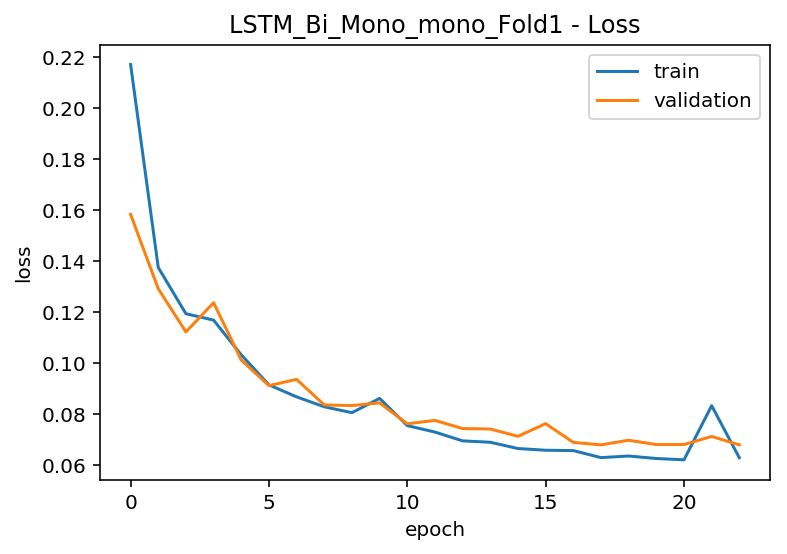

In [17]:
# LOAD HISTORY

date = "2020-10-14"
modeltype = "LSTM_Bi_Mono"
dataset = "mono"
network_size = 100
fold = 1

history_load = pd.read_csv('{0}_{1}_{2}_NS-{3}/{1}_{2}_NS-{3}_History_Fold{4}.csv'.format(date,modeltype,dataset, network_size,fold)).to_dict()
for series in history_load:
    data = list(history_load[series].values())
    history_load[series]=data
    
plt.plot(history_load['loss'], label='train')
plt.plot(history_load['val_loss'], label='validation')
plt.title('{0}_{1}_Fold{2} - Loss'.format(modeltype, dataset, fold))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()


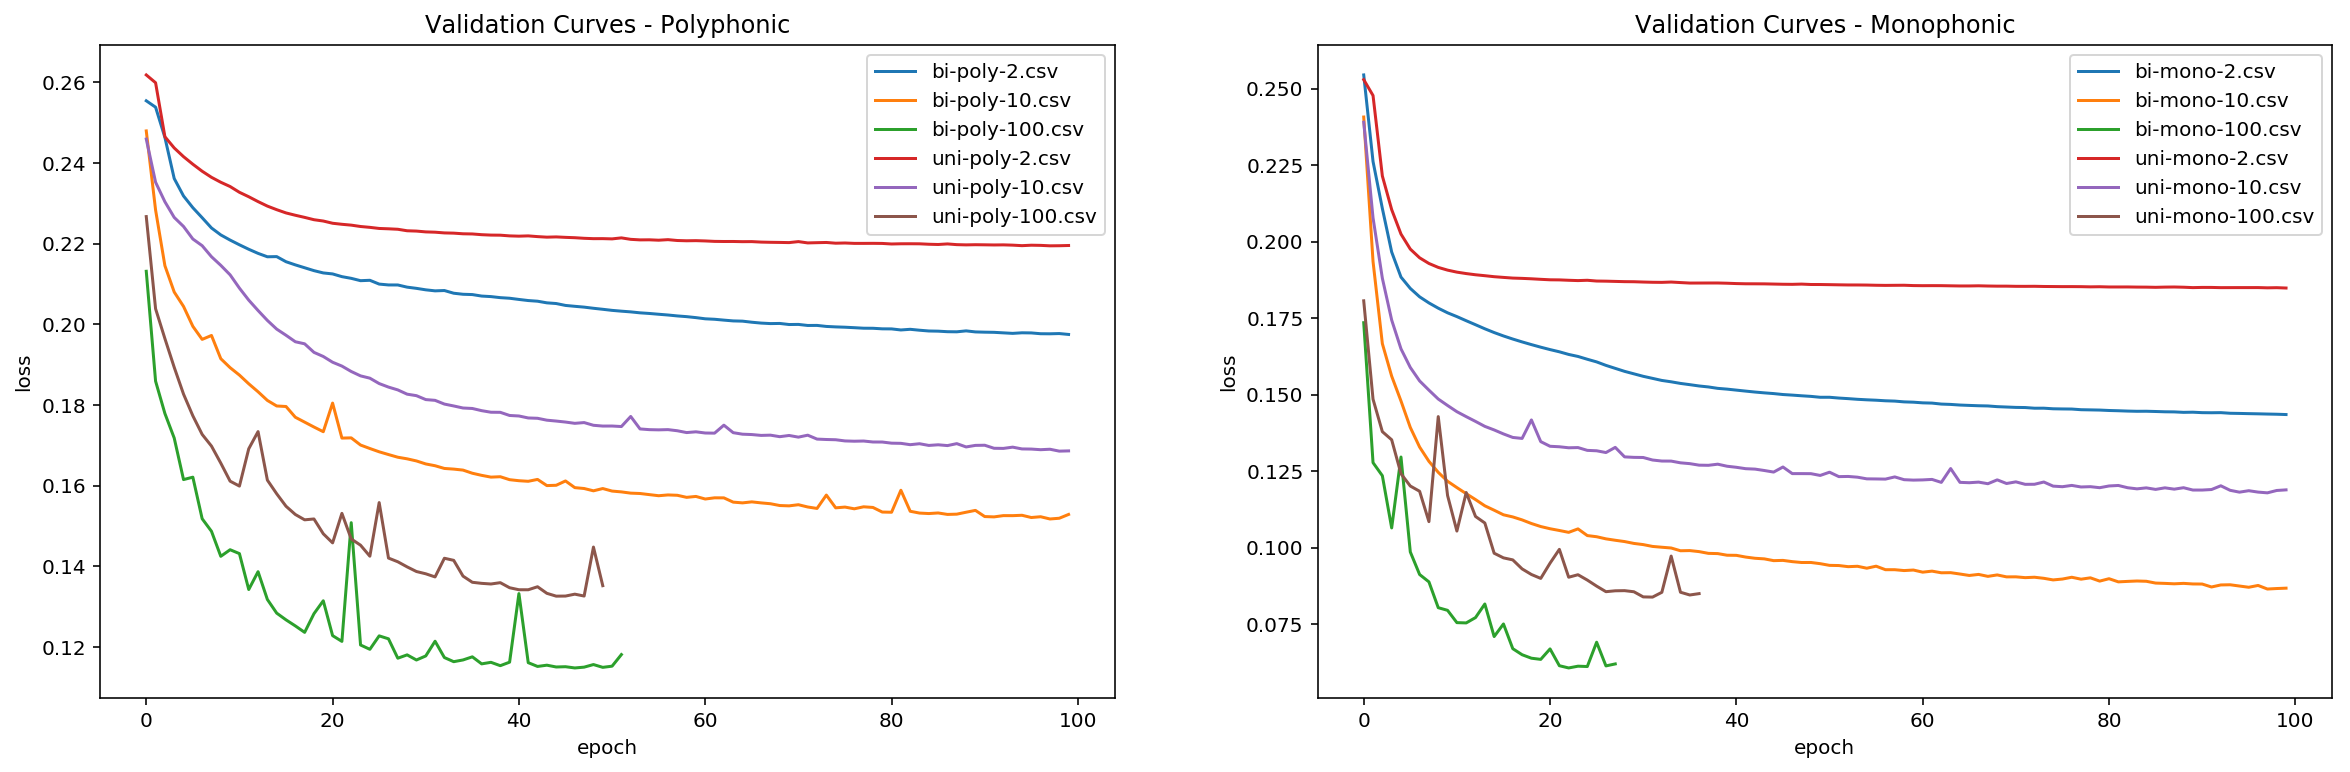

In [20]:
# LOAD HISTORY

files_poly = ["bi-poly-2.csv", "bi-poly-10.csv", "bi-poly-100.csv", "uni-poly-2.csv", "uni-poly-10.csv", "uni-poly-100.csv"]
files_mono = ["bi-mono-2.csv", "bi-mono-10.csv", "bi-mono-100.csv", "uni-mono-2.csv", "uni-mono-10.csv", "uni-mono-100.csv"]

history_data = []
for file in files_poly:
    history_load = pd.read_csv('cv_histories/{0}'.format(file)).to_dict()
    for series in history_load:
        data = list(history_load[series].values())
        history_load[series]=data
    history_data.append(history_load)
    
labelled_history = zip(files_poly, history_data)

history_data_mono = []
for file in files_mono:
    history_load = pd.read_csv('cv_histories/{0}'.format(file)).to_dict()
    for series in history_load:
        data = list(history_load[series].values())
        history_load[series]=data
    history_data_mono.append(history_load)
    
labelled_history_mono = zip(files_mono, history_data_mono)


fig, ax = plt.subplots(1, 2, figsize=(20, 6))
for history in labelled_history:
    #plt.plot(history['loss'], label='train')
    ax[0].plot(history[1]['val_loss'], label=history[0])
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Validation Curves - Polyphonic')
ax[0].legend()

for history in labelled_history_mono:
    #plt.plot(history['loss'], label='train')
    ax[1].plot(history[1]['val_loss'], label=history[0])
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].set_title('Validation Curves - Monophonic')
ax[1].legend()

fig.savefig('CV-ValCurves.png')

